In [2]:
# 1. Fix the "MessageFactory" error by downgrading Protobuf
!pip install -q "protobuf<3.20,>=3.9.2"

# 2. Fix the "UNKNOWN ERROR (303)" by upgrading TensorFlow specific to Kaggle's GPU
!pip install -q "tensorflow[and-cuda]" 

# 3. IMPORTANT: After running this cell, you must RESTART the session.
# Go to the menu bar: Run > Restart Session (or simply restart the kernel)

ERROR: Could not find a version that satisfies the requirement protobuf<3.20,>=3.9.2 (from versions: none)
ERROR: No matching distribution found for protobuf<3.20,>=3.9.2
ERROR: Could not find a version that satisfies the requirement protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3 (from tensorflow[and-cuda]) (from versions: none)
ERROR: No matching distribution found for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os

# Check if GPU is working now
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define paths (Using the Kaggle input directory)
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# Continue with the rest of the code...

2025-11-26 09:25:25.253408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764149125.517957      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764149125.606308      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Num GPUs Available:  0


2025-11-26 09:25:46.128462: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# accurate paths for Kaggle notebooks
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# Verify the paths exist before proceeding
import os
print("Checking folders...")
if os.path.exists(train_dir):
    print(f"✅ Found training data at: {train_dir}")
else:
    print(f"❌ Could not find {train_dir}")

Checking folders...
✅ Found training data at: /kaggle/input/chest-xray-pneumonia/chest_xray/train


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define the correct paths
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# 2. Create the Data Generators (The "Loader")
# We zoom and flip training images to make the model smarter
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# We only rescale test data (never fake the test data!)
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Actually load the images from the folders
print("Loading Training Set...")
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary' # Binary because we only have 2 options: Normal or Pneumonia
)

print("Loading Test Set...")
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Loading Training Set...
Found 5216 images belonging to 2 classes.
Loading Test Set...
Found 624 images belonging to 2 classes.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the Brain
model = Sequential()

# Layer 1: Convolution (The Eye)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolution
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten: Prepare for the brain
model.add(Flatten())

# Layer 4: Full Connection (The Neural Network)
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5)) # Turn off 50% of neurons to prevent memorizing answers
model.add(Dense(units=1, activation='sigmoid')) # Output: 0 or 1

# Compile: Get ready to learn
# We track Recall because missing a sick patient is bad!
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall()])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,489 (1.34 MB)

 Trainable params: 351,489 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    training_set,
    epochs=10, # The model will study the data 10 times
    validation_data=test_set
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 670ms/step - accuracy: 0.7265 - loss: 0.5641 - recall: 0.9622 - val_accuracy: 0.8510 - val_loss: 0.3458 - val_recall: 0.8744
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 454ms/step - accuracy: 0.8730 - loss: 0.2944 - recall: 0.9179 - val_accuracy: 0.8510 - val_loss: 0.3332 - val_recall: 0.9487
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.9071 - loss: 0.2183 - recall: 0.9428 - val_accuracy: 0.8670 - val_loss: 0.3001 - val_recall: 0.9487
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 450ms/step - accuracy: 0.9222 - loss: 0.2007 - recall: 0.9476 - val_accuracy: 0.8958 - val_loss: 0.2709 - val_recall: 0.9462
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 448ms/step - accuracy: 0.9320 - loss: 0.1719 - recall: 0.9511 - val_accuracy: 0.9006 - val_loss: 0.2874 - val_recall: 0.9564
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.9347 - loss: 0.1693 - recall: 0.9526 - val_accuracy: 0.9038 - val_loss: 0.2770 - val_

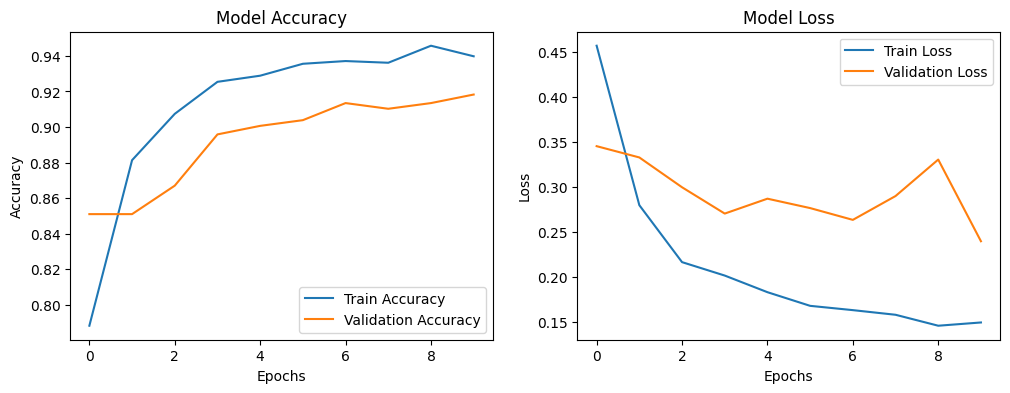

In [8]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss (Error rate)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [9]:
# Save the model to a file
model.save('pneumonia_model_v1.h5')

print("✅ Model saved successfully as 'pneumonia_model_v1.h5'")

✅ Model saved successfully as 'pneumonia_model_v1.h5'


📸 Testing on image: person175_bacteria_835.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Raw Prediction Value: 0.9992303252220154
🚨 AI Diagnosis: PNEUMONIA DETECTED


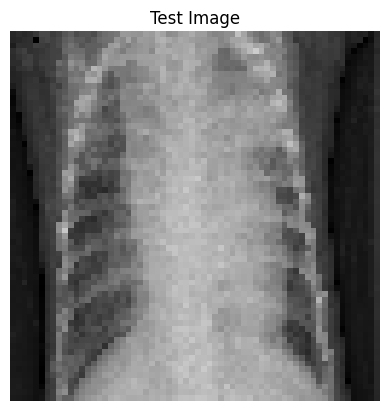

In [19]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Automatically find a real image from the PNEUMONIA folder
folder_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'
file_list = os.listdir(folder_path) # Get a list of all files
real_image_name = file_list[50] # Just pick the first one found
img_path = os.path.join(folder_path, real_image_name)

print(f"📸 Testing on image: {real_image_name}")

# 2. Preprocess the image (Must be 48x48 like the training data)
test_image = image.load_img(img_path, target_size=(64, 64))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0) # Add batch dimension
test_image_array = test_image_array / 255.0 # Normalize

# 3. Predict
prediction = model.predict(test_image_array)

# 4. Show Result
print(f"Raw Prediction Value: {prediction[0][0]}")

# Since we used sigmoid, output is between 0 and 1
# usually: 0 = Normal, 1 = Pneumonia (depending on folder order)
if prediction[0][0] > 0.5:
    print("🚨 AI Diagnosis: PNEUMONIA DETECTED")
else:
    print("✅ AI Diagnosis: NORMAL")

# Show the image
plt.imshow(test_image)
plt.axis('off')
plt.title("Test Image")
plt.show()